# Strategy Name
---
*Description*: Describe briefly what the strategy does and what it the hypothesis behind it.

In [1]:
import pandas as pd
from qbtx.dataloader.binance_loader import BinanceDataLoader
from qbtx.engine.engine import Strategy, Portfolio, Backtester
from qbtx.evaluate.PerformanceReport import PerformanceReport
from qbtx.evaluate.MonteCarloSimulation import MonteCarloSimulator

import seaborn as sns

sns.set_theme()

%load_ext autoreload

%autoreload 2

## Strategy Development
---
This first part is for preparing the data, defining the strategy class, and running the backtest.

### Data Loading and Preprocessing
1. Load the data and perform any necessary preprocessing steps. This might include handling missing values, normalizing data, or creating additional features.
2. Create a `Portfolio` object with the loaded data.

In [2]:
loader = BinanceDataLoader()
portfolio = Portfolio(
    assets=loader.load(
        symbols=["ETHUSDT", "BTCUSDT", "ADAUSDT", "XRPUSDT", "LTCUSDT"],
        columns=["close"],
    )
)

### Strategy Class Definition
Define the strategy class that inherits from `Strategy`. Implement the `__init__` method to initialize the strategy parameters and the `run` method to define the trading logic. The `run` method should include:
- Logic to calculate indicators or signals based on the data (given as parameters and not a class attribute).
- Logic to generate buy/sell signals based on the indicators.
The `run` method should return the generated signals as a pandas Series or DataFrame.

> **Warning:**  
> When implementing the `Strategy` class, ensure that your logic avoids lookahead bias. All calculations and signal generations should only use information available up to the current time step, without referencing future data. This is crucial for realistic backtesting results.

In [3]:
class SampleStrategy(Strategy):
    def __init__(self, window=20):
        self.window = window

    def run(self, data):
        # Example logic: Calculate a simple moving average and generate signals
        sma = data["close"].rolling(window=self.window).mean()
        signals = pd.Series(index=data.index, data=0)
        signals[data["close"] > sma] = 1  # Buy signal
        signals[data["close"] < sma] = -1  # Sell signal
        return signals.shift(1).dropna()

### Strategy Backtesting
1. Create an instance of the `Backtester` class with the portfolio and strategy.
2. Run the backtest using the `run` method of the `Backtester` instance.
3. Retrieve the results using the `get_combined_results` method of the `Backtester

In [4]:
engine = Backtester(
    portfolio=portfolio,
    strategy=SampleStrategy,
    strategy_kwargs={"window": 20},
    slippage=0.001,
    fee=0.001,
)
engine.run()
results = engine.get_combined_results()

Running backtests: 100%|██████████| 5/5 [00:00<00:00, 152.94it/s]


## Results Analysis
---
This part is for analyzing the results of the backtest, including performance metrics, visualizations, and any insights gained from the strategy's performance.

### Performance Metrics
#### Portfolio Returns

In [5]:
report = PerformanceReport(
    strategy_returns=results.get("returns"),
    benchmark="SP500",
    strategy_name="Sample Strategy",
)
report.compute_summary_metrics()

,Sample Strategy,SP500
Start Date,2017-08-17,2017-08-17
End Date,2025-05-31,2025-05-31
Duration (weeks),406.3,406.3
Exposure Time (%),100.00,100.00
Start Value,"$10,000.00","$10,000.00"
Final Value,"$77,984.16","$24,327.84"
Peak Value,"$390,770.96","$25,284.46"
Total Return (%),679.84%,143.28%
Annualized Return (%),19.95%,8.19%
Annualized Volatility (%),56.94%,16.33%


#### Trade Statistics

In [6]:
results.get("trade_stats")

,0
Num Trades,1454
Win Rate [%],39.75%
Avg Gross Return [%],2.99%
Avg Net Return [%],2.59%
Best Trade [%],301.98%
Worst Trade [%],-39.19%
Avg Duration (days),9.3
Long Trades,726
Short Trades,728


### Results Visualization

In [7]:
report.plot()

In [8]:
report.plot_monthly_returns()

### Trades Analysis

In [9]:
results.get("all_trades").head()

,entry_time,exit_time,entry_price,exit_price,position_size,gross_return,net_return,fee_paid,slippage_paid,total_cost,duration,direction,ticker
0,2017-09-06,2017-09-07,335.00,334.49,-1.0,0.1525,-0.2472,0.66949,0.66949,1.33898,1,short,ETHUSDT
1,2017-09-07,2017-09-08,334.49,302.99,1.0,-9.4173,-9.7985,0.63748,0.63748,1.27496,1,long,ETHUSDT
2,2017-09-08,2017-09-24,302.99,282.00,-1.0,7.4433,7.0571,0.58499,0.58499,1.16998,16,short,ETHUSDT
3,2017-09-24,2017-09-25,282.00,294.42,1.0,4.4043,3.9954,0.57642,0.57642,1.15284,1,long,ETHUSDT
4,2017-09-25,2017-09-26,294.42,287.90,-1.0,2.2647,1.8691,0.58232,0.58232,1.16464,1,short,ETHUSDT


### Monte Carlo Simulation
Monte Carlo simulation is a powerful technique to assess the robustness of your trading strategy by simulating various scenarios. This section will guide you through running Monte Carlo simulations with and without replacement.

- **With Replacement**: This method allows for the same data points to be selected multiple times, simulating a scenario where trades can be repeated.
- **Without Replacement**: This method ensures that each data point is only selected once, simulating a scenario where trades are unique. In other words, the returns are simply shuffled.

In [47]:
mcs = MonteCarloSimulator(returns=results.get("returns"))

#### Monte Carlo Simulation without replacement

In [48]:
df_without_replacement = mcs.run_without_replacement()
MonteCarloSimulator.calculate_performance_table(
    df_without_replacement, results.get("returns")
)

,Cumulative Return (p.a.),Volatility (p.a.),Sharpe Ratio,Maximal Drawdown,95% Drawdown,Profit Factor
Original Strategy,19.95%,56.95%,0.35,-82.20%,-1.03%,1.12
95th percentile,19.95%,56.95%,0.35,-65.17%,0.00%,1.12
75th percentile,19.95%,56.95%,0.35,-72.51%,-0.50%,1.12
50th percentile,19.95%,56.95%,0.35,-78.38%,-0.96%,1.12
25th percentile,19.95%,56.95%,0.35,-85.11%,-1.37%,1.12
10th percentile,19.95%,56.95%,0.35,-88.99%,-1.74%,1.12
5th percentile,19.95%,56.95%,0.35,-90.81%,-1.90%,1.12
1th percentile,19.95%,56.95%,0.35,-95.26%,-2.38%,1.12
0th percentile,19.95%,56.95%,0.35,-95.93%,-2.38%,1.12


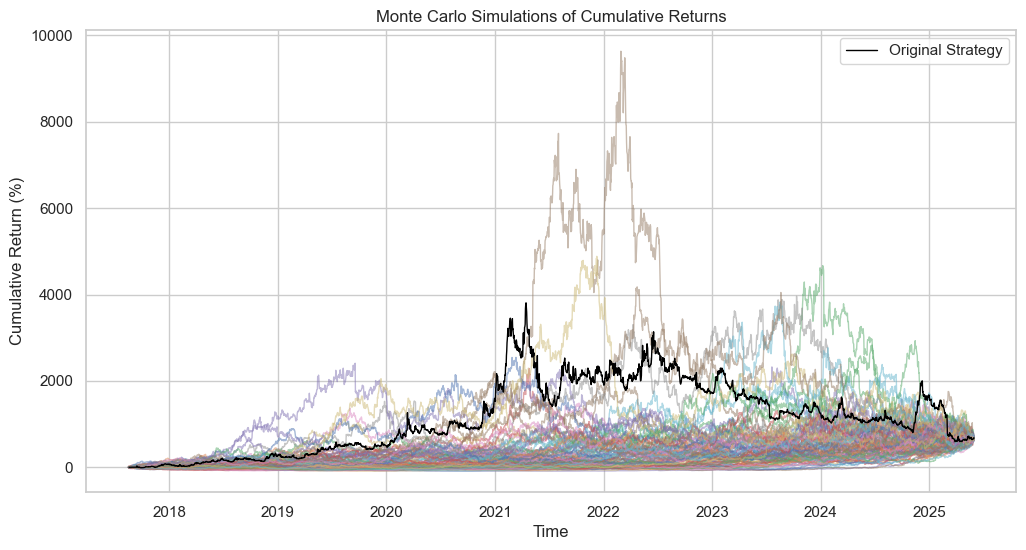

In [49]:
MonteCarloSimulator.plot_simulations(
    df_without_replacement, original_returns=results.get("returns")
)

#### Monte Carlo Simulation with replacement

In [50]:
df_with_replacement = mcs.run_with_replacement()
MonteCarloSimulator.calculate_performance_table(
    df_with_replacement, results.get("returns")
)

,Cumulative Return (p.a.),Volatility (p.a.),Sharpe Ratio,Maximal Drawdown,95% Drawdown,Profit Factor
Original Strategy,19.95%,56.95%,0.35,-82.20%,-1.03%,1.12
95th percentile,56.58%,60.28%,0.92,-61.62%,0.00%,1.23
75th percentile,30.93%,58.25%,0.55,-70.39%,0.00%,1.16
50th percentile,18.20%,57.23%,0.32,-78.43%,-0.96%,1.12
25th percentile,6.03%,55.86%,0.10,-85.83%,-2.95%,1.08
10th percentile,-3.64%,54.90%,-0.06,-93.58%,-9.76%,1.04
5th percentile,-8.68%,54.13%,-0.16,-94.91%,-14.46%,1.02
1th percentile,-15.59%,52.76%,-0.27,-96.35%,-30.18%,1.00
0th percentile,-15.67%,52.49%,-0.28,-98.51%,-31.51%,0.99


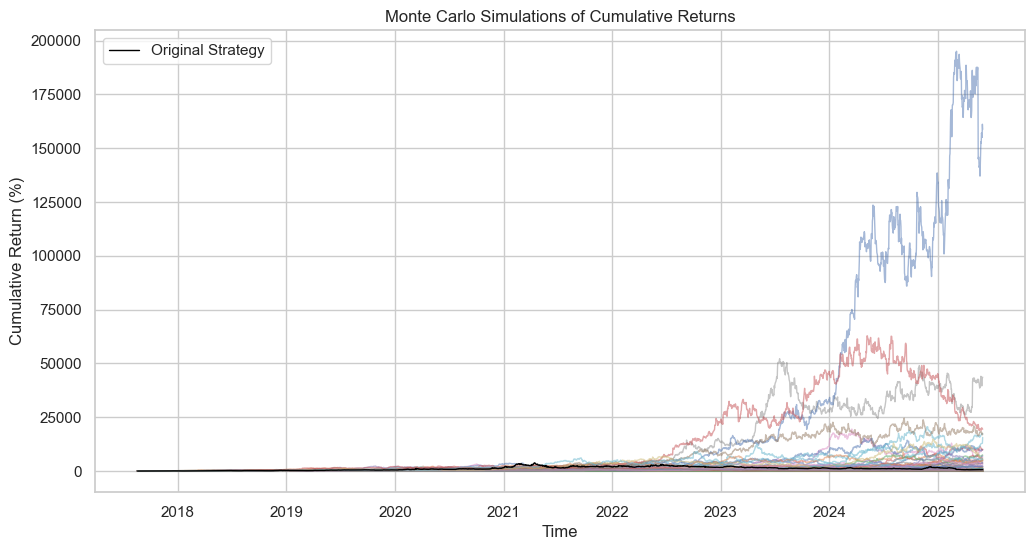

In [51]:
MonteCarloSimulator.plot_simulations(
    df_with_replacement, original_returns=results.get("returns")
)